# KNMI data visualization

<em>TODO: WRITE INTRODUCTION (LATER)</em>

In the [previous Notebook in the series](./01-knmi_data_retrieval.ipynb) we dived into some examples for data retrieval from the KNMI web script service. In this notebook we will build upon the gained knowledge and delve into examples of data analysis.

### Disclaimer
I am not officially affiliated with KNMI, and the scripts and insights provided in this Jupyter Notebook are offered on an unofficial basis for educational and exploratory purposes.

## Preparation steps
We will start by importing the required external and internal modules, scripts and libraries.

### Import external libraries
Note: these are only the external libraries used directly within this Notebook. The Python helper scripts, imported in the subsequent step, may require the installation of additional libraries.

In [1]:
import datetime
import pandas as pd

from functools import partial, reduce


### Internal imports
In the code below the custom Python helper scripts powering the workflow in this Jupyter Notebook are imported.

In [2]:
import knmi_meteo_ingest
import knmi_meteo_transform
import knmi_meteo_visualize

## Examples

### Example 1: Summarize occurrences of rainiest hour slots throughout The Netherlands for a selection of years

#### Obtain the raw dataset from KNMI service

In [3]:
# Set year as variable
YEAR = 2023

In [4]:
# Set start and end dates (inclusive) for data retrieval
start_date = datetime.date(YEAR, 1, 1)
end_date = datetime.date(YEAR, 12, 31)

# Optional: uncomment below to make end_date exclusive
# end_date -= datetime.timedelta(days=1)

In [5]:
# Get dataset from KNMI web script service
df_day = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                            meteo_params_list=None,
                                            start_date=start_date,
                                            end_date=end_date)

#### Clean (transform) dataset
We can improve the readibility of the dataset by applying some preset transformations on the "raw" dataset we just ingested. 

As part of this transformation, all parameters are converted to whole units of measurements (e.g. m/s, J/cm2, °C) for better interpretability. Furthermore the column names are converted to a more readable format.

In [6]:
# Apply transformations to the raw dataset
df_day_cleaned = knmi_meteo_transform.transform_param_values(df_day)

In [7]:
# Show the result
df_day_cleaned

,station_code,date,vect_avg_wind_dir,vect_avg_wind_speed,day_avg_wind_speed,max_hour_avg_wind_speed,hour_slot_max_avg_wind_speed,min_hour_avg_wind_speed,hour_slot_min_avg_wind_speed,max_gust_speed,...,hour_slot_min_visibility,max_visibility_cat,hour_slot_min_visibility,cloudiness_in_eights_cat,day_avg_humidity,max_humidity,hour_slot_max_humidity,min_humidity,hour_slot_min_humidity,evap_ref
0,209,2023-01-01,215.0,9.2,9.6,14.0,1.0,3.0,22.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,209,2023-01-02,266.0,6.1,6.9,8.0,2.0,5.0,1.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,209,2023-01-03,196.0,8.3,8.8,15.0,22.0,3.0,3.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,209,2023-01-04,233.0,13.7,14.1,17.0,2.0,12.0,18.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,209,2023-01-05,245.0,8.2,9.0,12.0,2.0,6.0,13.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17150,391,2023-12-27,176.0,2.7,3.1,5.0,18.0,1.0,1.0,11.0,...,NaN,NaN,NaN,NaN,0.82,0.95,1.0,0.53,21.0,0.2
17151,391,2023-12-28,225.0,4.8,4.8,6.0,11.0,4.0,1.0,13.0,...,NaN,NaN,NaN,NaN,0.72,0.79,4.0,0.67,17.0,0.3
17152,391,2023-12-29,236.0,4.9,5.0,6.0,1.0,4.0,13.0,15.0,...,NaN,NaN,NaN,NaN,0.81,0.92,13.0,0.72,1.0,0.1
17153,391,2023-12-30,213.0,3.0,3.5,5.0,1.0,3.0,6.0,9.0,...,NaN,NaN,NaN,NaN,0.80,0.87,8.0,0.73,14.0,0.3


#### Summarize dataset

In [8]:
# Get distribution overview of numeric cols
df_day_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
station_code,17155.0,297.361702,46.271796,209.00,260.00,286.00,331.000,391.00
vect_avg_wind_dir,16741.0,187.695657,91.645513,1.00,110.00,212.00,249.000,360.00
vect_avg_wind_speed,16741.0,4.629096,2.760371,0.10,2.60,4.10,6.100,17.60
day_avg_wind_speed,16744.0,5.240952,2.699477,0.40,3.30,4.70,6.700,18.20
max_hour_avg_wind_speed,16741.0,7.685264,3.343342,1.00,5.00,7.00,10.000,30.00
hour_slot_max_avg_wind_speed,16741.0,10.907353,6.365938,1.00,6.00,11.00,15.000,24.00
min_hour_avg_wind_speed,16741.0,2.782331,2.251414,0.00,1.00,2.00,4.000,15.00
hour_slot_min_avg_wind_speed,16741.0,9.724509,8.549831,1.00,1.00,6.00,19.000,24.00
max_gust_speed,16742.0,12.056146,4.514247,2.00,9.00,11.00,15.000,41.00
hour_slot_max_gust_speed,16742.0,11.755167,6.309347,1.00,7.00,12.00,16.000,24.00


- Which time(s) of the day tended to be the rainiest/sunniest?
- Which of the measured locations were most/least windy?
- What were the total sums for rainfall and sunshine for the year of interest, and how did this vary throughout The Netherlands?
- Where and when did we see extreme rainfall or drought?
- At what time of the day did we typically see the lowest and highest temperatures, and is there a difference per region?

In [9]:
# TODO: Make boxplot of distribution of hour_slot_max_rain_hour_sum (to show all stations' distributions in one go)
sel_cols = ["date", "station_code", "max_rain_hour_sum",
            "hour_slot_max_rain_hour_sum"]

df_max_rain_h = df_day_cleaned[sel_cols]

In [10]:
# Show the result
df_max_rain_h

,date,station_code,max_rain_hour_sum,hour_slot_max_rain_hour_sum
0,2023-01-01,209,NaN,NaN
1,2023-01-02,209,NaN,NaN
2,2023-01-03,209,NaN,NaN
3,2023-01-04,209,NaN,NaN
4,2023-01-05,209,NaN,NaN
...,...,...,...,...
17150,2023-12-27,391,1.7,8.0
17151,2023-12-28,391,0.0,1.0
17152,2023-12-29,391,5.0,20.0
17153,2023-12-30,391,0.0,1.0


In [11]:
is_dry = df_max_rain_h["max_rain_hour_sum"] < 0.1

df_max_rain_h.loc[is_dry,
                  "hour_slot_max_rain_hour_sum"] = -1

df_max_rain_h

,date,station_code,max_rain_hour_sum,hour_slot_max_rain_hour_sum
0,2023-01-01,209,NaN,NaN
1,2023-01-02,209,NaN,NaN
2,2023-01-03,209,NaN,NaN
3,2023-01-04,209,NaN,NaN
4,2023-01-05,209,NaN,NaN
...,...,...,...,...
17150,2023-12-27,391,1.7,8.0
17151,2023-12-28,391,0.0,-1.0
17152,2023-12-29,391,5.0,20.0
17153,2023-12-30,391,0.0,-1.0


In [12]:
# Remove "max_rain_hour_sum" column
drop_cols = ["max_rain_hour_sum"]
df_max_rain_h = df_max_rain_h.drop(columns=drop_cols)

In [13]:
# Show the result
df_max_rain_h

,date,station_code,hour_slot_max_rain_hour_sum
0,2023-01-01,209,NaN
1,2023-01-02,209,NaN
2,2023-01-03,209,NaN
3,2023-01-04,209,NaN
4,2023-01-05,209,NaN
...,...,...,...
17150,2023-12-27,391,8.0
17151,2023-12-28,391,-1.0
17152,2023-12-29,391,20.0
17153,2023-12-30,391,-1.0


In [14]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_max_rain_h_pivot = (df_max_rain_h
                       .pivot(index="date",
                              columns="station_code"))

# Flatten pivot table to single index
df_max_rain_h_pivot.columns = (df_max_rain_h_pivot.columns
                               .get_level_values(1))

In [15]:
df_max_rain_h_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,21.0,NaN,22.0,21.0,NaN,NaN,21.0,21.0,20.0,...,NaN,20.0,20.0,19.0,20.0,8.0,9.0,19.0,17.0,19.0
2023-01-02,NaN,5.0,NaN,4.0,14.0,NaN,NaN,5.0,2.0,4.0,...,NaN,3.0,16.0,6.0,17.0,7.0,7.0,8.0,17.0,8.0
2023-01-03,NaN,24.0,NaN,24.0,24.0,NaN,NaN,24.0,18.0,24.0,...,NaN,24.0,24.0,24.0,24.0,24.0,9.0,9.0,-1.0,9.0
2023-01-04,NaN,1.0,NaN,3.0,8.0,NaN,NaN,6.0,3.0,6.0,...,NaN,8.0,10.0,1.0,1.0,13.0,2.0,16.0,13.0,14.0
2023-01-05,NaN,16.0,NaN,18.0,16.0,NaN,NaN,18.0,19.0,16.0,...,NaN,16.0,16.0,16.0,16.0,20.0,17.0,16.0,16.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,8.0,NaN,10.0,9.0,NaN,NaN,9.0,12.0,9.0,...,NaN,8.0,8.0,6.0,8.0,6.0,8.0,6.0,7.0,8.0
2023-12-28,NaN,23.0,NaN,22.0,22.0,NaN,NaN,-1.0,19.0,22.0,...,NaN,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2023-12-29,NaN,17.0,NaN,-1.0,16.0,NaN,NaN,2.0,22.0,10.0,...,NaN,15.0,15.0,14.0,23.0,13.0,14.0,16.0,8.0,20.0


In [16]:
# Only keep cols if less than fraction of values missing
max_na_frac = 0.1

# Select columns to keep (using the condition)
keep_cols = [col for col in df_max_rain_h_pivot.columns 
             if (df_max_rain_h_pivot[col].isna().sum() 
                 <= max_na_frac * len(df_max_rain_h_pivot))]

# Apply selection to our DataFrame
df_max_rain_h_pivot = df_max_rain_h_pivot[keep_cols]

In [17]:
df_max_rain_h_pivot

station_code,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,21.0,22.0,21.0,21.0,21.0,20.0,20.0,3.0,21.0,24.0,...,19.0,20.0,20.0,19.0,20.0,8.0,9.0,19.0,17.0,19.0
2023-01-02,5.0,4.0,14.0,5.0,2.0,4.0,6.0,5.0,15.0,5.0,...,2.0,3.0,16.0,6.0,17.0,7.0,7.0,8.0,17.0,8.0
2023-01-03,24.0,24.0,24.0,24.0,18.0,24.0,24.0,24.0,24.0,24.0,...,24.0,24.0,24.0,24.0,24.0,24.0,9.0,9.0,-1.0,9.0
2023-01-04,1.0,3.0,8.0,6.0,3.0,6.0,10.0,3.0,9.0,3.0,...,1.0,8.0,10.0,1.0,1.0,13.0,2.0,16.0,13.0,14.0
2023-01-05,16.0,18.0,16.0,18.0,19.0,16.0,18.0,17.0,20.0,19.0,...,14.0,16.0,16.0,16.0,16.0,20.0,17.0,16.0,16.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,8.0,10.0,9.0,9.0,12.0,9.0,8.0,11.0,9.0,12.0,...,5.0,8.0,8.0,6.0,8.0,6.0,8.0,6.0,7.0,8.0
2023-12-28,23.0,22.0,22.0,-1.0,19.0,22.0,23.0,22.0,24.0,22.0,...,-1.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2023-12-29,17.0,-1.0,16.0,2.0,22.0,10.0,16.0,2.0,17.0,22.0,...,13.0,15.0,15.0,14.0,23.0,13.0,14.0,16.0,8.0,20.0


In [18]:
# Placeholder for DataFrame of counts
df_max_rain_h_counts = pd.DataFrame()

# Build up the 'counts' DataFrame col by col
for col in df_max_rain_h_pivot.columns:
    df_max_rain_h_counts[col] = (df_max_rain_h_pivot[col]
                                 .value_counts())

# Order the hour slots in index; ascending
df_max_rain_h_counts.sort_index(ascending=True,
                                inplace=True)

# Rename index
df_max_rain_h_counts.index.names = ['hour_slot']

In [19]:
# Print the result
df_max_rain_h_counts

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
-1.0,156,157,161,164,153,161,158,161,158,148,...,173,158,167,167,168,165,165,165,166,162
1.0,14,11,12,16,11,10,9,14,12,17,...,13,13,7,8,12,8,6,12,13,9
2.0,7,14,11,11,11,10,8,11,14,7,...,7,6,7,11,3,5,7,6,5,5
3.0,11,11,8,10,6,8,9,11,6,9,...,11,11,12,8,12,11,8,3,7,9
4.0,11,11,9,10,9,11,8,12,6,8,...,9,10,9,5,4,11,9,10,8,7
5.0,12,7,8,11,11,12,9,5,6,14,...,5,7,3,7,5,8,8,4,2,9
6.0,12,7,10,7,10,6,4,9,4,17,...,10,14,10,8,8,6,5,6,7,4
7.0,7,11,7,9,12,4,17,15,13,9,...,6,4,10,12,10,7,5,8,8,6
8.0,4,6,9,8,4,5,8,9,8,5,...,3,10,6,5,12,9,15,6,9,5


In [20]:
# Drop dry-day observations (-1) from the dataset
dry_day_idxs = [-1.0]

df_max_rain_h_counts.drop(dry_day_idxs, axis='index',
                          inplace=True)

In [21]:
# Show the result
df_max_rain_h_counts

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
1.0,14,11,12,16,11,10,9,14,12,17,...,13,13,7,8,12,8,6,12,13,9
2.0,7,14,11,11,11,10,8,11,14,7,...,7,6,7,11,3,5,7,6,5,5
3.0,11,11,8,10,6,8,9,11,6,9,...,11,11,12,8,12,11,8,3,7,9
4.0,11,11,9,10,9,11,8,12,6,8,...,9,10,9,5,4,11,9,10,8,7
5.0,12,7,8,11,11,12,9,5,6,14,...,5,7,3,7,5,8,8,4,2,9
6.0,12,7,10,7,10,6,4,9,4,17,...,10,14,10,8,8,6,5,6,7,4
7.0,7,11,7,9,12,4,17,15,13,9,...,6,4,10,12,10,7,5,8,8,6
8.0,4,6,9,8,4,5,8,9,8,5,...,3,10,6,5,12,9,15,6,9,5
9.0,7,5,6,10,9,6,3,10,8,10,...,12,7,6,6,8,3,7,8,6,11


In [22]:
# Normalize data by total counts per column
df_max_rain_h_slot_pcs = df_max_rain_h_counts.apply(lambda x: 100 * x / x.sum())

In [23]:
# Prettify index columns
df_max_rain_h_slot_pcs.index = (df_max_rain_h_slot_pcs
                                .index
                                .astype(int)
                                .astype(str))

In [24]:
# Show the result
df_max_rain_h_slot_pcs

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
1,6.698565,5.288462,5.882353,7.960199,5.188679,4.901961,4.347826,6.862745,5.797101,7.834101,...,6.770833,6.280193,3.535354,4.040404,6.091371,4.0,3.0,6.0,6.532663,4.433498
2,3.349282,6.730769,5.392157,5.472637,5.188679,4.901961,3.864734,5.392157,6.763285,3.225806,...,3.645833,2.898551,3.535354,5.555556,1.522843,2.5,3.5,3.0,2.512563,2.463054
3,5.263158,5.288462,3.921569,4.975124,2.830189,3.921569,4.347826,5.392157,2.898551,4.147465,...,5.729167,5.314010,6.060606,4.040404,6.091371,5.5,4.0,1.5,3.517588,4.433498
4,5.263158,5.288462,4.411765,4.975124,4.245283,5.392157,3.864734,5.882353,2.898551,3.686636,...,4.687500,4.830918,4.545455,2.525253,2.030457,5.5,4.5,5.0,4.020101,3.448276
5,5.741627,3.365385,3.921569,5.472637,5.188679,5.882353,4.347826,2.450980,2.898551,6.451613,...,2.604167,3.381643,1.515152,3.535354,2.538071,4.0,4.0,2.0,1.005025,4.433498
6,5.741627,3.365385,4.901961,3.482587,4.716981,2.941176,1.932367,4.411765,1.932367,7.834101,...,5.208333,6.763285,5.050505,4.040404,4.060914,3.0,2.5,3.0,3.517588,1.970443
7,3.349282,5.288462,3.431373,4.477612,5.660377,1.960784,8.212560,7.352941,6.280193,4.147465,...,3.125000,1.932367,5.050505,6.060606,5.076142,3.5,2.5,4.0,4.020101,2.955665
8,1.913876,2.884615,4.411765,3.980100,1.886792,2.450980,3.864734,4.411765,3.864734,2.304147,...,1.562500,4.830918,3.030303,2.525253,6.091371,4.5,7.5,3.0,4.522613,2.463054
9,3.349282,2.403846,2.941176,4.975124,4.245283,2.941176,1.449275,4.901961,3.864734,4.608295,...,6.250000,3.381643,3.030303,3.030303,4.060914,1.5,3.5,4.0,3.015075,5.418719


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import colors as cl
from matplotlib import colormaps as cm

"""
Created custom function below to allow for many more
options for creating cyclic-style colormaps.

You can choose any colormap of your liking.

Make sure the midpoints of your first and second cmaps
look alike (or choose them to be the same as in here),
so that you end up with a cyclic colormap in any case.
"""
def symm_lin_max_center(N, N_max, f_min, f_max):
    """Symm. lin. func with min at x=0, x=N; max at N/2."""
    # Get slope of function (twice of normal lin. func.)
    a = 2 * (f_max - f_min) / N_max
    
    # Apply +lin. func. up to N_max / 2
    if N < N_max / 2:
        return a * N + f_min
    # Apply -lin. func. beyond N / 2
    else:
        return -a * (N - N_max / 2) + f_max

# Create boxplot with Pandas & Matplotlib
ax, bp = df_max_rain_h_slot_pcs.T.plot(
    # Create a boxplot
    kind="box",
    # Make markers for the means
    showmeans=True,
    # Properties for boxes
    boxprops=dict(linestyle='-',
                  linewidth=1.5),
    # Properties for outliers
    flierprops=dict(marker='x',
                    linestyle='none',
                    linewidth=0),
    # Properties for mean symbols
    meanprops=dict(marker='o',
                   markeredgecolor='none',
                   markerfacecolor='w',
                   markersize=2),
    # Properties for median lines
    medianprops=dict(linestyle='-.', 
                     color='w',
                     linewidth=1),
    # Properties for IQR whisker lines
    whiskerprops=dict(linestyle='-',
                      linewidth=0.75),
    # Properties for IQR cap lines
    capprops=dict(linestyle='-', linewidth=0.5),
    # Show outliers, grid and/or apply rotation
    showfliers=True, grid=True, rot=0,
    # Return dict to allow for custom plot settings
    patch_artist=True,
    # Return figure and its elements for customization
    return_type='both')

# Choose colormap for first and second halves of plots
# (Note: these may be set different)
cmap_a = cm.get_cmap("inferno")
cmap_b = cm.get_cmap("inferno")

# Set min and max colors (cmap edges tend to be a bit too much)
c_max = 0.85
c_min = 0.125

# Number of categories is equal to number of boxes to draw
n_cats = len(bp["boxes"])

# Set cyclic run through parts of the colormap (symmetrically);
# preset all variables except for iteration value i
partial_f = partial(symm_lin_max_center,
                    N_max=n_cats, f_min=c_min, f_max=c_max)

# Build up the colormap colors; walk through colormap A
# in first half & through colormap B in second half
colors = []
for i in range(n_cats):
    is_first_half = ((i // (n_cats // 2)) == 0)
    cmap = (cmap_a if is_first_half else cmap_b)
    colors.append(cl.to_hex(cmap(partial_f(i))))

# Set boxplot + outlier item colors based on colormaps
for i in range(n_cats):
    bp['boxes'][i].set_facecolor(colors[i])
    bp['boxes'][i].set_edgecolor(colors[i])
    bp['fliers'][i].set_markeredgecolor(colors[i])

    # Whiskers, caps occur twice per box; correct for that
    for item in ['whiskers', 'caps']:
        bp[item][i].set_color(colors[i // 2])
        bp[item][n_cats + i].set_color(colors[(n_cats + i) // 2])

# Set custom styles for plot and ticks
custfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Add horizontal line at "expected" hour slot value if 
# rainfall were perfectly uniform each day (= 100%/24)
ax.axhline(y=100/n_cats, color=colors[0],
           linestyle='--',
           linewidth=1, zorder=1)

# Add x, y labels and title; use custom font
ax.set_xlabel("Hour slot (1= 0-1 UT; 2= 1-2 UT, ...)", **custfont)
ax.set_ylabel("Occurrence (in %)", **custfont)

# Set title and subtitle text and styles
title_text = f"Hour slots with maximum daily rainfall - Dutch KNMI stations ({YEAR})"
subttl_text = ("Means: circles, medians: lines, uniform reference: dashdot line,"
               " outliers (non-IQR): crosses")

# Get central x-pos; max y-pos as title plotting locations
x_mid = sum(ax.get_xlim()) / len(ax.get_xlim())
y_max = ax.get_ylim()[-1]

# Add title and subtitles as text on the Axes
ax.text(x_mid, 1.2*y_max, title_text, fontsize=14,
        ha='center', va='top', **custfont)
ax.text(x_mid, 1.11*y_max, subttl_text, fontsize=9,
        ha='center', va='top', **custfont)

# Customize font of the tick markers
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)

# Customize the grid layout
ax.grid(True, color="grey", linewidth=0.15, linestyle="-")

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(10,8), dpi=1200)

fig.axes.append(ax)

# Finally, show the plot
plt.show()

NameError: name 'df_max_rain_h_slot_pcs' is not defined

### TODO: DRAW CONCLUSIONS, FORM HYPOTHESES


### Rain hour slot pattern comparison for 2001-2020 

(Mention that I actually wanted to take 1991-2020, but some of the 1990s data was returned empty; probably not yet measured back then.)

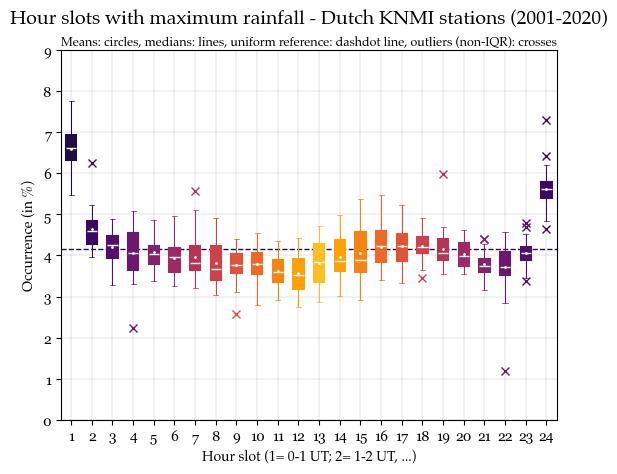

<Figure size 7200x4800 with 0 Axes>

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

df_h_list = []

# Fetch KNMI data year by year to prevent service overflow
for yr in range(2001, 2021):
    df_h_test = (knmi_meteo_visualize
                 .knmi_hourslot_percentage_df(start_date=datetime.date(yr, 1, 1), 
                                              end_date=datetime.date(yr, 12, 31),
                                              return_as_counts=True))
    df_h_list.append(df_h_test)

# Use a reduce function to sum all count-dfs from the result list at once
df_h_cts = reduce(lambda x, y: x.add(y, fill_value=0), df_h_list)

# Convert the summed counts to percentages (apply over columns)
df_h = df_h_cts.apply(lambda x: 100 * x / x.sum(), axis=1)

# Create boxplot of maximum rainfall occurrence per hour slot
title_txt = "Hour slots with maximum rainfall - Dutch KNMI stations (2001-2020)"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h, title_text=title_txt,
                                                  subtitle_text=subtitle_txt)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()


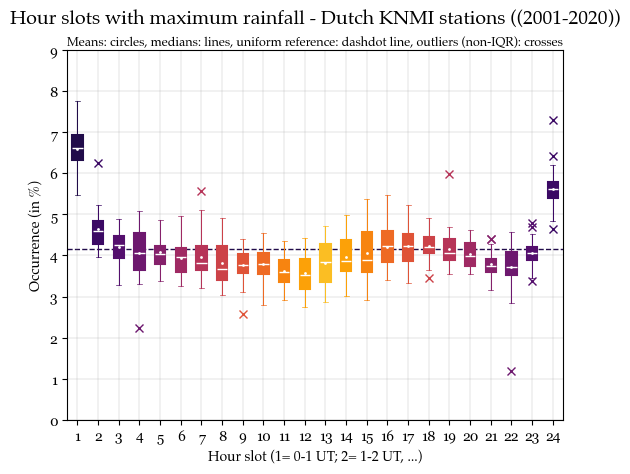

<Figure size 7200x4800 with 0 Axes>

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

# Fetch KNMI data year by year to prevent service overflow
df_h_slots = knmi_meteo_visualize.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END)

# Create boxplot of maximum rainfall occurrence per hour slot
title_txt = f"Hour slots with maximum rainfall - Dutch KNMI stations (({YEAR_START}-{YEAR_END}))"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_slots, 
                                                  title_text=title_txt,
                                                  subtitle_text=subtitle_txt)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

### Maximum temperature hour slot pattern (2001-2020)

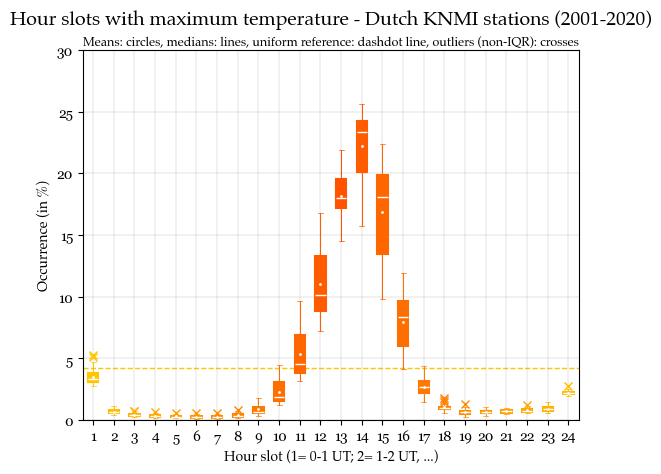

<Figure size 7200x4800 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

df_h_slots = knmi_meteo_visualize.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END,
    param_col="max_temp", hourslot_col="hour_slot_max_temp")

title_txt = f"Hour slots with maximum temperature - Dutch KNMI stations ({YEAR_START}-{YEAR_END})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_slots, title_text=title_txt,
                                                   subtitle_text=subtitle_txt,
                                                   cmap_name_a="autumn_r", cmap_name_b="autumn_r",
                                                   c_min=0.225, c_max=0.675)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(15, 10), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

### Max. avg. wind speed pattern (2001-2020)

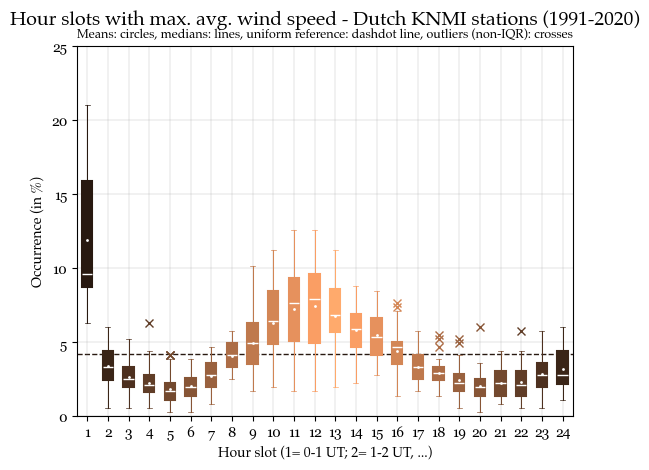

<Figure size 7200x4800 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

df_h_slots = knmi_meteo_visualize.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END,
    param_col="max_hour_avg_wind_speed",
    hourslot_col="hour_slot_max_avg_wind_speed")

title_txt = f"Hour slots with max. avg. wind speed - Dutch KNMI stations ({YEAR_START}-{YEAR_END})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_test, title_text=title_txt,
                                                   subtitle_text=subtitle_txt,
                                                   cmap_name_a="copper", cmap_name_b="copper")

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(15, 10), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()